# KPI Revenue

## Libraries

In [1]:
# importing all relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta
from matplotlib.dates import date2num

## Styles

In [2]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)

## Data reading

In [3]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    return trip_data

## KPI generation

In [4]:
%config IPCompleter.greedy=True

##### Main Processing

In [90]:
def generate_revenue_per_hour_for_city(data, city, start_date, end_date):
    '''
    Processes given data and calculates the revenue per hour for a given city in a given time window

    :param data: the dataFrame of a given city
    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    '''

    # sorting of data
    dat = data.sort_values(by=['datetime_start'], axis=0)
 
    def calc_revenue(x):
        '''
        Counts trip duration intervals for each trip, i.e. how much revenue each trip generated,
        by setting the revenue to the number of 30-minute durations fitting into the trip duration,
        and add 1 to the revenue if division of trip duration by 30-minute interval has a remainder
        
        Examples: 
        If a trip was 30 mins long: trip duration / 30 mins --> revenue = 1 
        If a trip was 1 hour 12 mins long: trip duration / 30 mins = 2, remainder = 12 --> revenue = 2+1 = 3
        
        :param x: a trip/row
        '''
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
                              
    # apply calculation to each row
    dat["revenue_per_trip"] = dat["trip_duration"].apply(lambda x: calc_revenue(x))
    print(dat.head())

    # set time window for the given data
    startDate = datetime.fromisoformat(start_date)
    endDate = datetime.fromisoformat(end_date)

    # select rows in the given time window
    dat_time_framed = dat.loc[(dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)]

    # Group data in the given time window by month, day and hours to get to specific hourly level
    # and aggregate the revenue per trip:
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    groupedByHours = dat_time_framed.groupby([times.month, times.day, times.hour])[
        "revenue_per_trip"].agg(num_of_trips_per_hour="count", total_revenue="sum")
    
    # reset index to get time labels as column labels
    groupedByHours.index.rename(["month", "day", "hour"], inplace=True)
    groupedByHours.reset_index(inplace=True)
    
    # generate date column
    groupedByHours["date"] = "2019-" + groupedByHours["month"].astype(str) + "-" +  groupedByHours["day"].astype(str) + " " + \
                             groupedByHours["hour"].astype(str) + ":00:00"

    # generate datetime column for checking of weekdays
    groupedByHours["datetime"] = [pd.to_datetime(d) for d in groupedByHours.date]

    # generate weekday column for later use
    groupedByHours["weekday"] = [dt.weekday() for dt in groupedByHours.datetime]
    
    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedByHours["is_weekday"] = groupedByHours["weekday"] <=4
    
    return groupedByHours


In [91]:
test = generate_revenue_per_hour_for_city(dataBr, city1, startDate, endDate)

       Unnamed: 0         day      time  b_number    city trip_duration   orig_lat  orig_lng   dest_lat  dest_lng  ... fleetsize_dayly fleetsize_monthly  distance  trip_duration_hours  avg_speed  rounded_time_hourly  temp  wind  rain  revenue_per_trip
48461       48461  2019-02-01  00:02:00     20918  bremen      00:12:00  53.082089  8.813730  53.093750  8.788500  ...              99               338  2.126097             0.200000  10.630484  2019-02-01 00:00:00  -2.0   3.8   0.0               1.0
41145       41145  2019-02-01  00:02:00     20862  bremen      00:12:00  53.082316  8.813245  53.093750  8.788500  ...              99               338  2.085053             0.200000  10.425267  2019-02-01 00:00:00  -2.0   3.8   0.0               1.0
36089       36089  2019-02-01  00:55:00     20820  bremen      00:34:00  53.073259  8.824117  53.066969  8.801864  ...              99               338  1.643011             0.566667   2.899432  2019-02-01 01:00:00  -1.7   3.3   0.0           

##### Read in data

In [6]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

##### Set City names and time window

In [7]:
city1 = "Bremen"
city2 = "Duesseldorf"
startDate = "2019-02-01 00:00:00"
endDate = "2019-06-30 23:59:00"

##### Prepare data for Bremen

In [89]:
dataDu.columns

Index(['Unnamed: 0', 'day', 'time', 'b_number', 'city', 'trip_duration', 'orig_lat', 'orig_lng', 'dest_lat', 'dest_lng', 'datetime_start', 'datetime_end', 'weekday', 'month', 'hour', 'week', 'fleetsize_weekly', 'fleetsize_dayly', 'fleetsize_monthly', 'distance', 'trip_duration_hours', 'avg_speed', 'rounded_time_hourly', 'temp', 'wind', 'rain'], dtype='object')

In [27]:
## USED FOR LINE PLOTS

bremen = generate_revenue_per_hour_for_city(dataBr, city1, startDate, endDate)
# group by specific day and sum up the revenue for each day
bremen_gr_d = bremen.groupby(["month","day"])["total_revenue"].agg(daily_total_revenue="sum").reset_index()
# generate date column 
bremen_gr_d["date"] = "2019-" + bremen_gr_d["month"].astype(str) + "-" +  bremen_gr_d["day"].astype(str)
# generate datetime column for plot labelling
bremen_gr_d["datetime"] = [pd.to_datetime(d) for d in bremen_gr_d.date]


## USED FOR BAR PLOTS

# group by hours from 0-24 over the whole time window and take the average
bremen_gr_hourly = bremen.groupby("hour")["total_revenue"].agg(average_hourly_total_revenue="mean")

# group by weekdays from 0-6 over the whole time window and take the average
bremen_gr_w = bremen.groupby(["month","day", "weekday"])["total_revenue"].agg(weekday_total_revenue="sum")
bremen_gr_weekday = bremen_gr_w.groupby("weekday")["weekday_total_revenue"].agg(average_weekday_total_revenue="mean")
# add a separate column to show if it is a working day
bremen_gr_weekday["is_working_day"] = bremen_gr_weekday.reset_index()["weekday"] <= 4

# group by months from 1-6 over the whole time window and sum up the revenue for each month
bremen_gr_monthly = bremen.groupby("month")["total_revenue"].agg(monthly_total_revenue="sum")

##### Prepare Data for Düsseldorf

In [82]:
## USED FOR LINE PLOTS

duesseldorf = generate_revenue_per_hour_for_city(dataDu, city1, startDate, endDate)
# group by specific day and sum up the revenue for each day
duesseldorf_gr_d = duesseldorf.groupby(["month","day"])["total_revenue"].agg(daily_total_revenue="sum").reset_index()
# generate date column 
duesseldorf_gr_d["date"] = "2019-" + duesseldorf_gr_d["month"].astype(str) + "-" +  duesseldorf_gr_d["day"].astype(str)
# generate datetime column for plot labelling
duesseldorf_gr_d["datetime"] = [pd.to_datetime(d) for d in bremen_gr_d.date]


## USED FOR BAR PLOTS

# group by hours from 0-24 over the whole time window and take the average
duesseldorf_gr_hourly = duesseldorf.groupby("hour")["total_revenue"].agg(average_hourly_total_revenue="mean")

# group by weekdays from 0-6 over the whole time window and take the average
duesseldorf_gr_w = duesseldorf.groupby(["month","day", "weekday"])["total_revenue"].agg(weekday_total_revenue="sum")
duesseldorf_gr_weekday = duesseldorf_gr_w.groupby("weekday")["weekday_total_revenue"].agg(average_weekday_total_revenue="mean")
# add a separate column to show if it is a working day
duesseldorf_gr_weekday["is_working_day"] = duesseldorf_gr_weekday.reset_index()["weekday"] <= 4

# group by months from 1-6 over the whole time window and sum up the revenue for each month
duesseldorf_gr_monthly = duesseldorf.groupby("month")["total_revenue"].agg(monthly_total_revenue="sum")

## Plotting

### Total Revenue per Hour and per day (absolute KPI values), all data points over the selected time interval

#### Bremen, hourly

In [57]:
# setting limits for y-axis of the following plots by taking the minimum and maximum values of the Bremen data set
yLimitHour = [0, bremen["total_revenue"].max()]
yLimitDay = [0, bremen_gr_d["daily_total_revenue"].max()]

(0.0, 273.0)

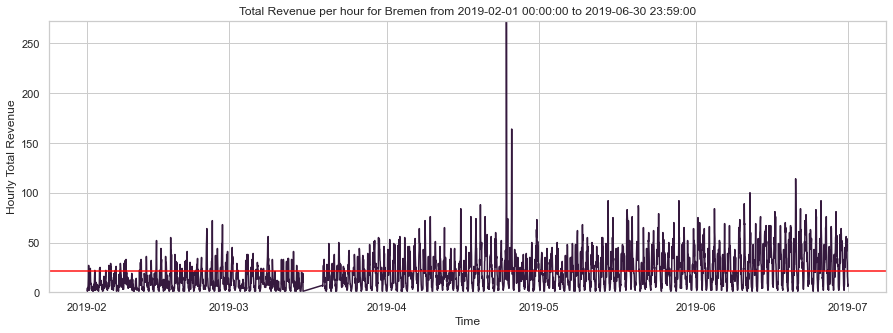

In [64]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate line plot
sns.lineplot(ax=ax, data=bremen.reset_index(), x="datetime", y="total_revenue", ci=None)
# draw line depicting the mean value
ax.axhline(y = bremen['total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
# set title and axis labels
ax.set_title(f"Total Revenue per hour for {city1} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")
# set axis scale limits
ax.set_ylim(yLimitHour)

#### Bremen, daily

(0.0, 1026.0)

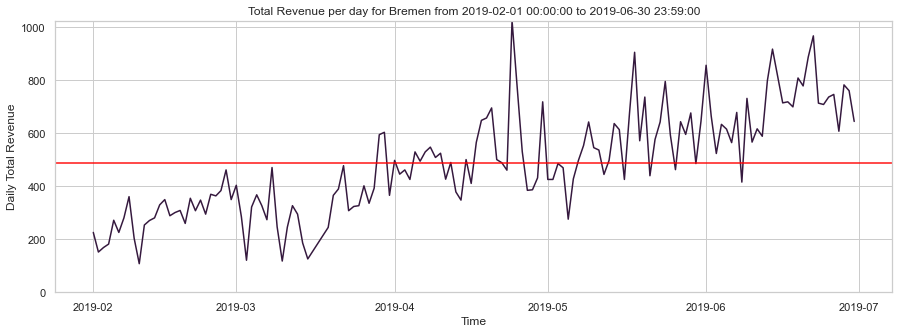

In [65]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.lineplot(ax=ax, data=bremen_gr_d, x="datetime", y="daily_total_revenue", ci=None)
ax.axhline(y = bremen_gr_d['daily_total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per day for {city1} from {startDate} to {endDate}")
ax.set_ylabel("Daily Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitDay)

#### Düsseldorf, hourly

(0.0, 273.0)

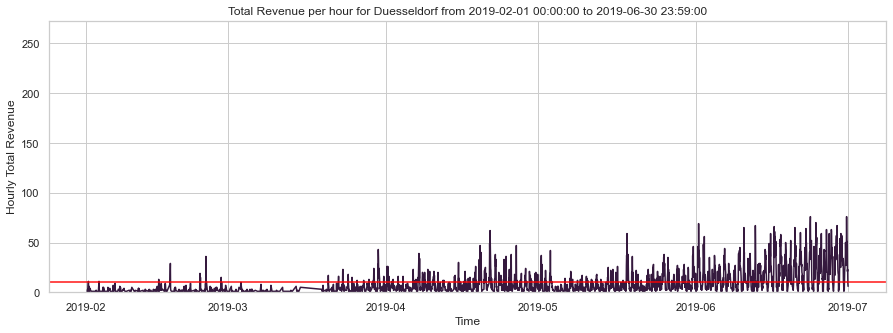

In [66]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
sns.lineplot(ax=ax, data=duesseldorf.reset_index(), x="datetime", y="total_revenue", ci=None)
ax.axhline(y = duesseldorf['total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per hour for {city2} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitHour)

#### Düsseldorf, Daily

(0.0, 1026.0)

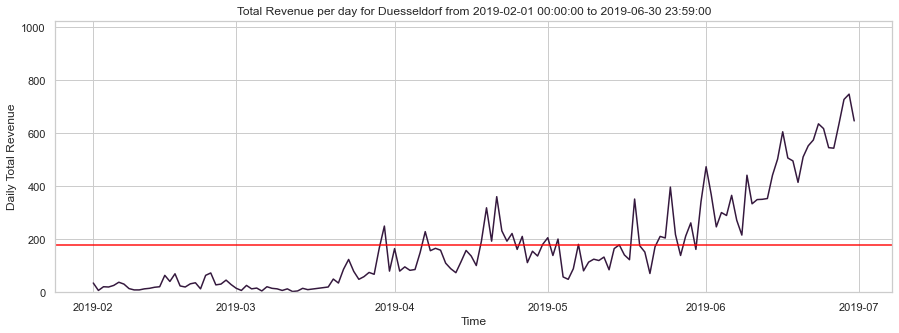

In [67]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
sns.lineplot(ax=ax, data=duesseldorf_gr_d, x="datetime", y="daily_total_revenue", ci=None)
ax.axhline(y = duesseldorf_gr_d['daily_total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per day for {city2} from {startDate} to {endDate}")
ax.set_ylabel("Daily Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitDay) # set y axis limit to maximum of daily values from bremen

#### Both Cities, hourly

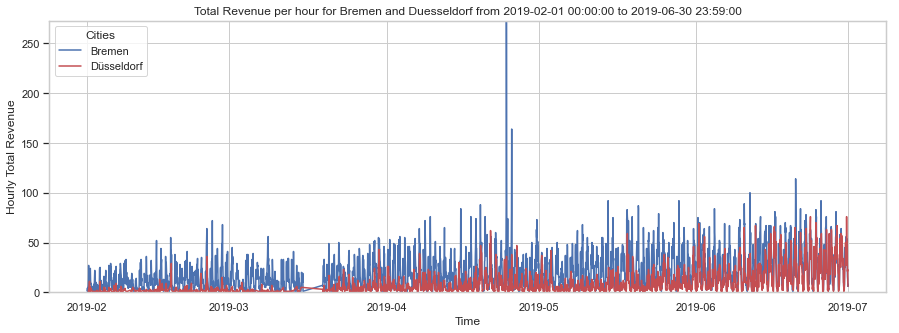

In [69]:
# generate figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

# generate line plot
sns.lineplot(ax=ax, data=bremen.reset_index(), x="datetime", y="total_revenue", color='b', ci=None, label="Bremen")
ax.set_title(f"Total Revenue per hour for {city1} and {city2} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")
ax.legend().set_visible(False) # removes a legend that would show up on the right side
ax.set_ylim(yLimitHour)

# generate twin axis to show the values of duesseldorf on the same figure
ax2 = ax.twinx()

# generate second line plot
sns.lineplot(ax=ax2, data=duesseldorf.reset_index(), x="datetime", y="total_revenue", color='r', ci=None, label="Düsseldorf")
ax2.set_ylim(yLimitHour) 
ax2.yaxis.set_visible(False) # make second y-axis invisible

# set handles and labels for legend manually
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, loc="upper left", title="Cities")

##### Note: Both data sets show an irregularity around 2019-03-20, seems to be some kind of error in the provided data

#### Both Cities, daily

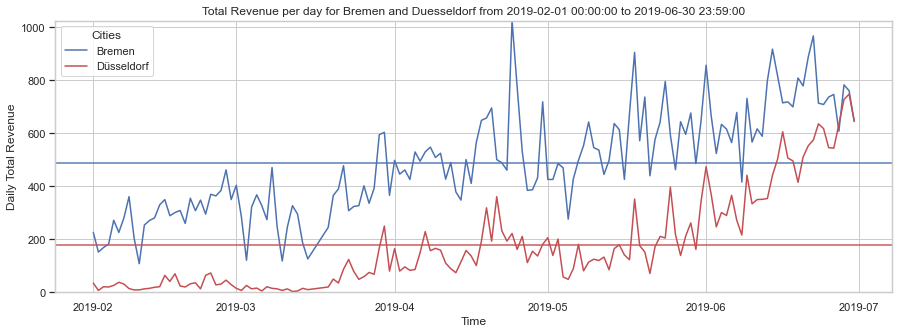

In [71]:
# generate figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

# generate line plot
sns.lineplot(ax=ax, data=bremen_gr_d, x="datetime", y="daily_total_revenue", color='b', ci=None, label="Bremen")
# draw line depicting the mean value
ax.axhline(y = bremen_gr_d['daily_total_revenue'].mean(), color='b', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per day for {city1} and {city2} from {startDate} to {endDate}")
ax.set_ylabel("Daily Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitDay)
ax.legend().set_visible(False) # removes a legend that would show up on the right side


# generate twin axis
ax2 = ax.twinx()

# generate second line plot
sns.lineplot(ax=ax2, data=duesseldorf_gr_d, x="datetime", y="daily_total_revenue", color='r', ci=None, label="Düsseldorf")
# draw line depicting the mean value
ax2.axhline(y = duesseldorf_gr_d['daily_total_revenue'].mean(), color='r', linewidth=2, alpha=.7)
ax2.set_ylim(yLimitDay)
ax2.yaxis.set_visible(False)

# set handles and labels for legend manually
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, loc="upper left", title="Cities")

### Total Revenue per Hour, averaged over the selected time interval and grouped over hours 0-24

In [76]:
# setting limits for y-axis of the following plots by taking the minimum and maximum values of the grouped data for bremen
yLimit_gr_hourly = [0, bremen_gr_hourly["average_hourly_total_revenue"].max()]
yLimit_gr_weekday = [0, bremen_gr_weekday["average_weekday_total_revenue"].max()]
yLimit_gr_monthly = [0, bremen_gr_monthly["monthly_total_revenue"].max()]

#### Bremen

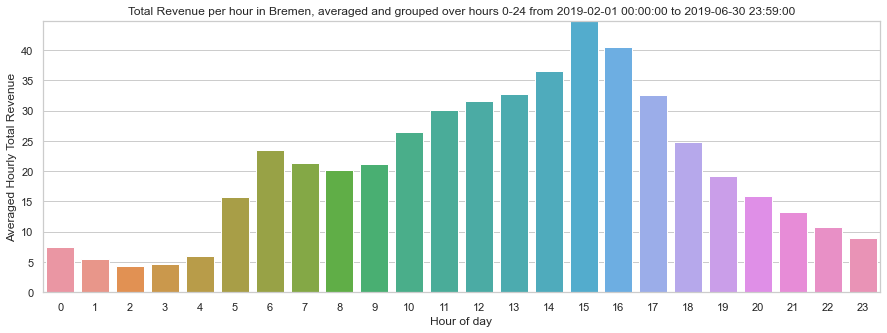

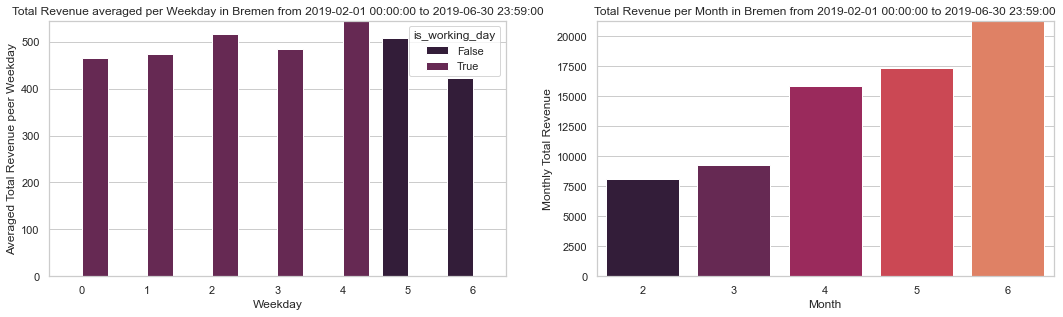

In [77]:
# create figure and axes for values grouped by hours 0-24
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.barplot(ax=ax, data=bremen_gr_hourly.reset_index(), x="hour", y="average_hourly_total_revenue", ci=None)
ax.set_title(f"Total Revenue per hour in {city1}, averaged and grouped over hours 0-24 from {startDate} to {endDate}")
ax.set_ylabel("Averaged Hourly Total Revenue")
ax.set_xlabel("Hour of day")
ax.set_ylim(yLimit_gr_hourly)


# create figure and axes for values grouped by weekdays and for monthly total values
fig2, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.barplot(ax=ax2, data=bremen_gr_weekday.reset_index(), x="weekday", y="average_weekday_total_revenue", hue="is_working_day", ci=None)
ax2.set_title(f"Total Revenue averaged per Weekday in {city1} from {startDate} to {endDate}")
ax2.set_ylabel("Averaged Total Revenue peer Weekday")
ax2.set_xlabel("Weekday")
ax2.set_ylim(yLimit_gr_weekday)

sns.barplot(ax=ax3, data=bremen_gr_monthly.reset_index(), x="month", y="monthly_total_revenue", ci=None)
ax3.set_title(f"Total Revenue per Month in {city1} from {startDate} to {endDate}")
ax3.set_ylabel("Monthly Total Revenue")
ax3.set_xlabel("Month")
ax3.set_ylim(yLimit_gr_monthly)

fig2.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25) # adjust spacing for overlapping plot titles

#### Düsseldorf

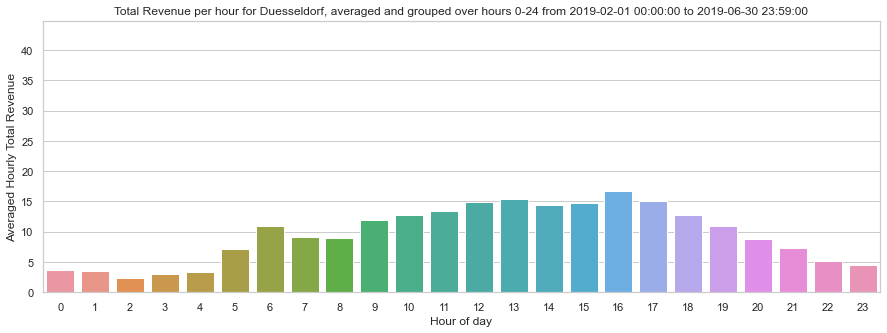

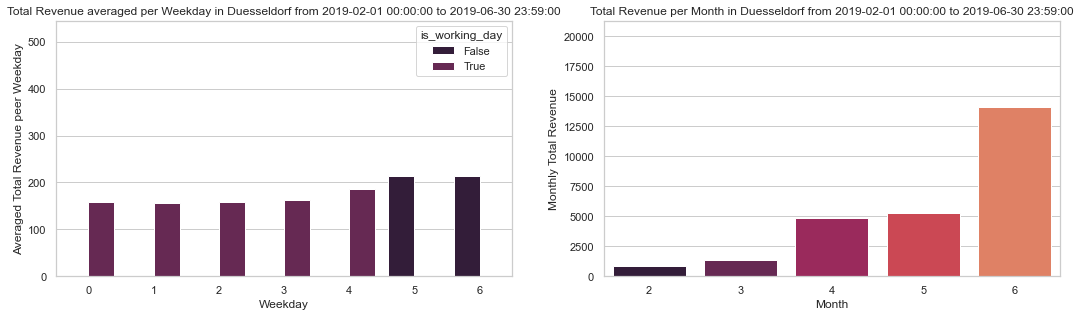

In [83]:
# create figure and axes for values grouped by hours 0-24
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.barplot(ax=ax, data=duesseldorf_gr_hourly.reset_index(), x="hour", y="average_hourly_total_revenue", ci=None)
ax.set_title(f"Total Revenue per hour for {city2}, averaged and grouped over hours 0-24 from {startDate} to {endDate}")
ax.set_ylabel("Averaged Hourly Total Revenue")
ax.set_xlabel("Hour of day")
ax.set_ylim(yLimit_gr_hourly)

# create figure and axes for values grouped by weekdays and for monthly total values
fig2, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.barplot(ax=ax2, data=duesseldorf_gr_weekday.reset_index(), x="weekday", y="average_weekday_total_revenue", hue="is_working_day", ci=None)
ax2.set_title(f"Total Revenue averaged per Weekday in {city2} from {startDate} to {endDate}")
ax2.set_ylabel("Averaged Total Revenue peer Weekday")
ax2.set_xlabel("Weekday")
ax2.set_ylim(yLimit_gr_weekday)

# generate plots
sns.barplot(ax=ax3, data=duesseldorf_gr_monthly.reset_index(), x="month", y="monthly_total_revenue", ci=None)
ax3.set_title(f"Total Revenue per Month in {city2} from {startDate} to {endDate}")
ax3.set_ylabel("Monthly Total Revenue")
ax3.set_xlabel("Month")
ax3.set_ylim(yLimit_gr_monthly)

fig2.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)